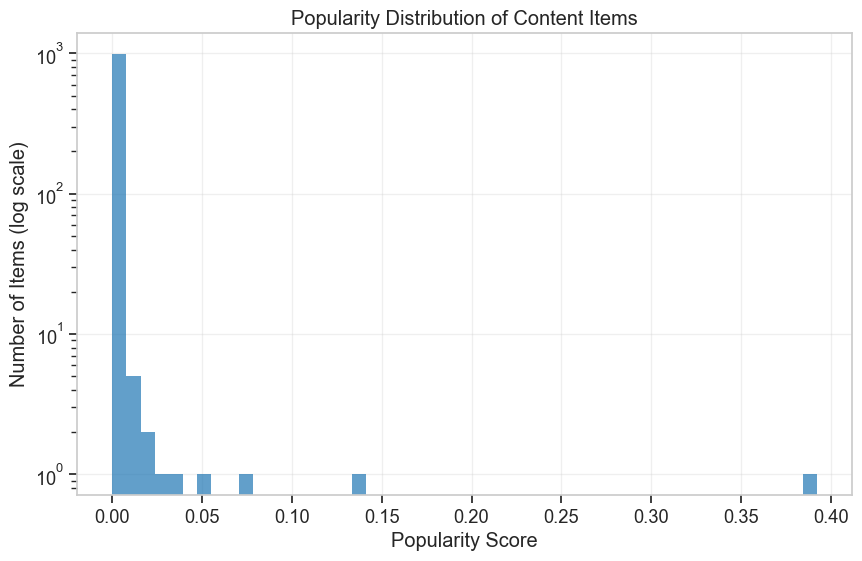

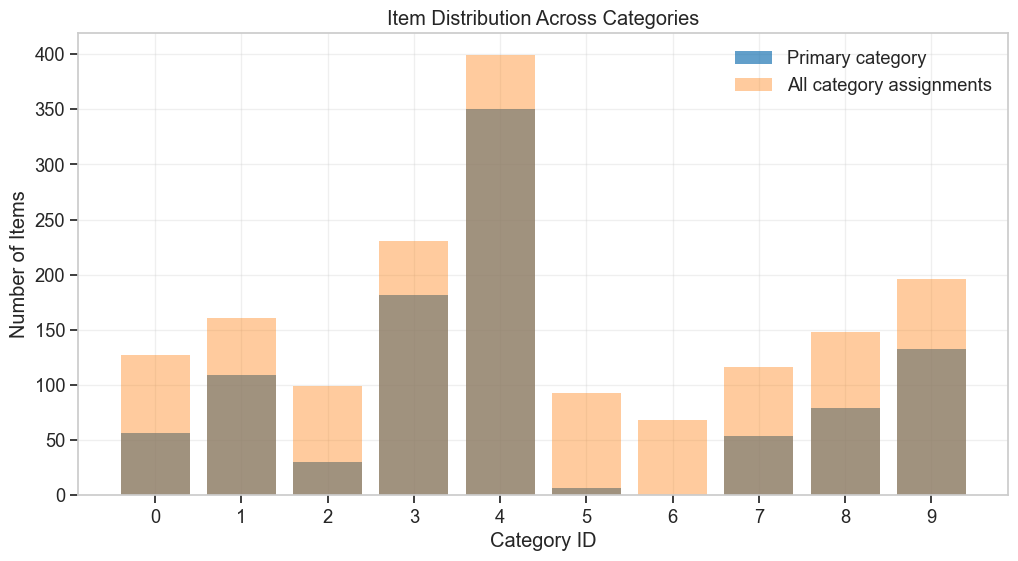

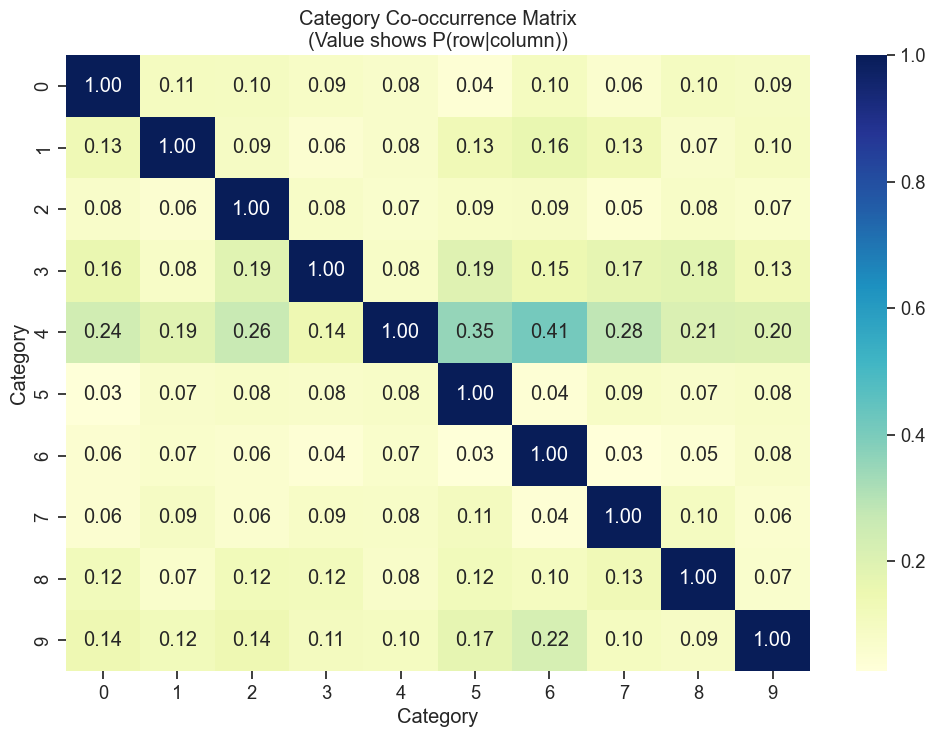

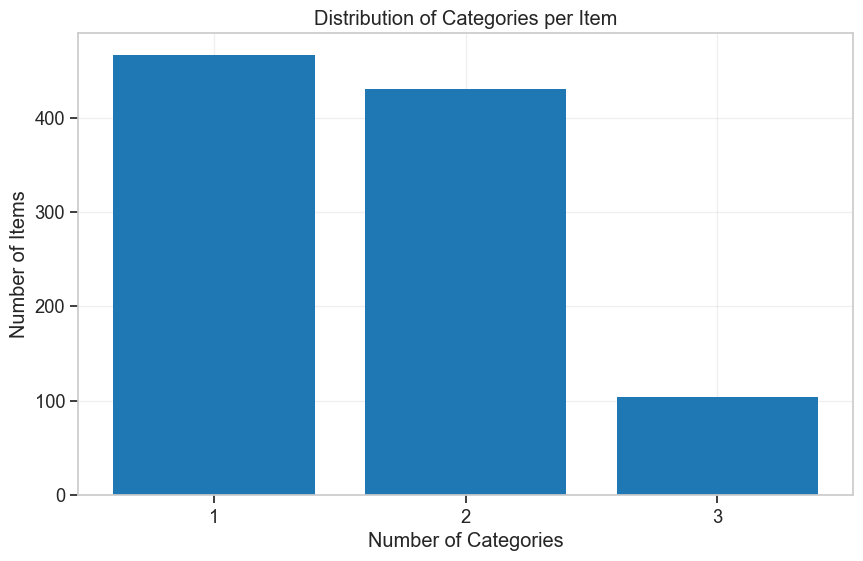

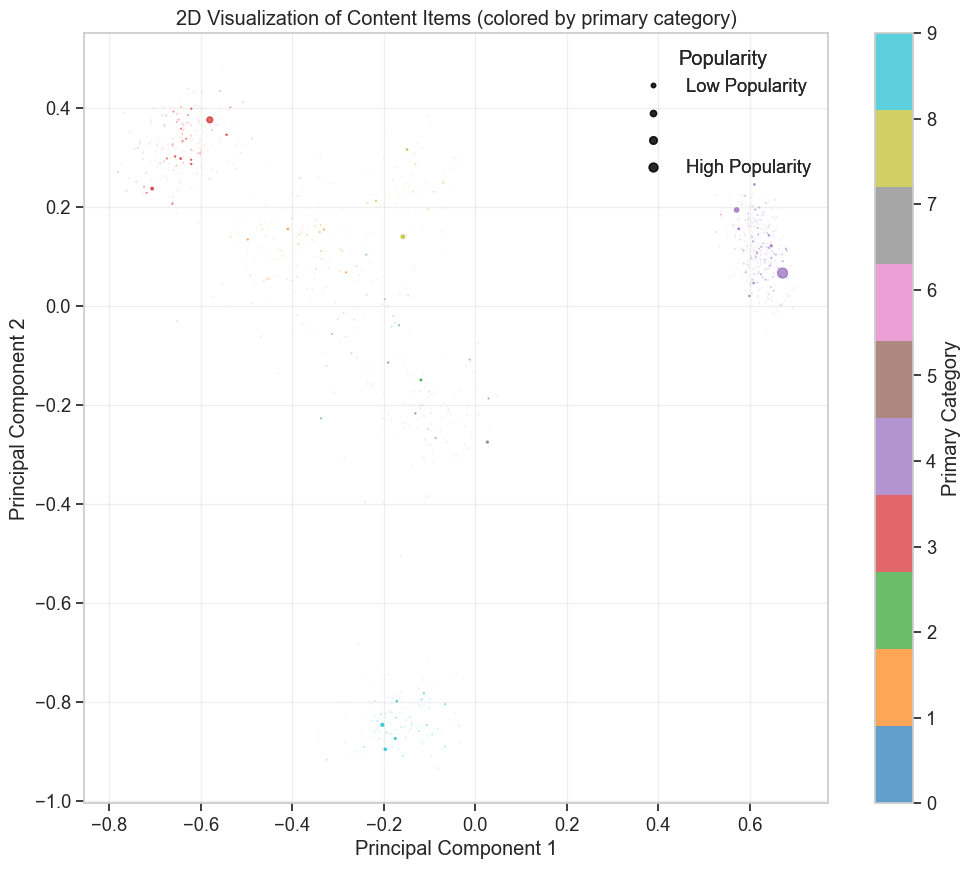

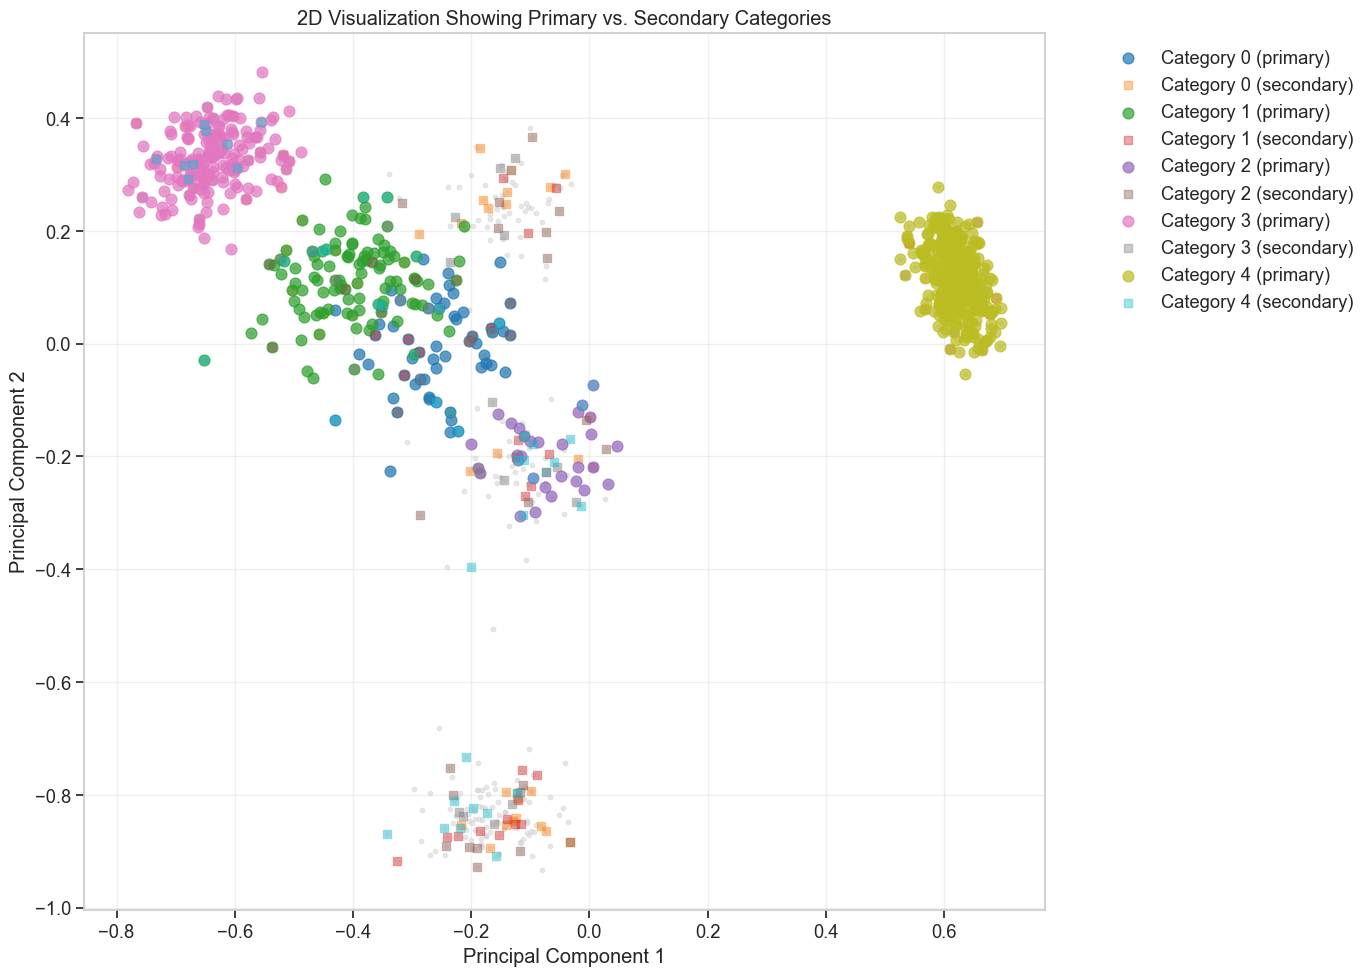

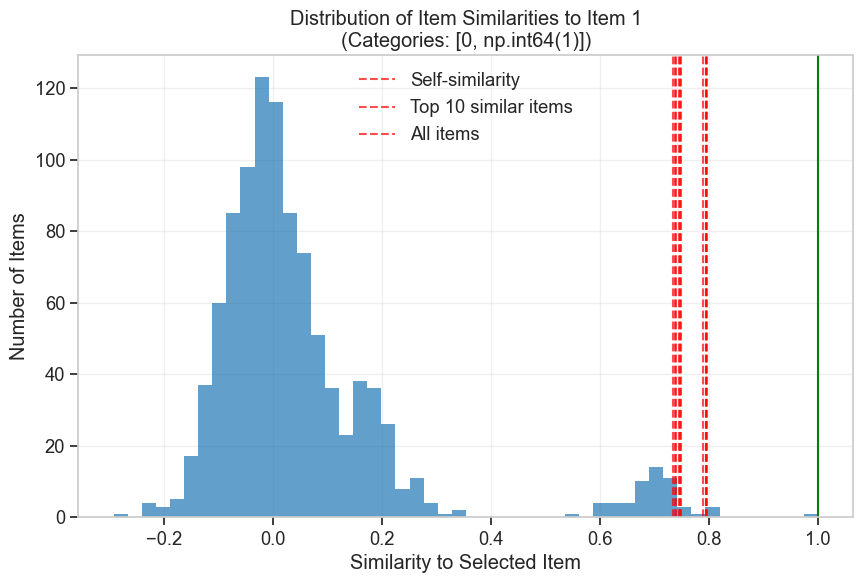

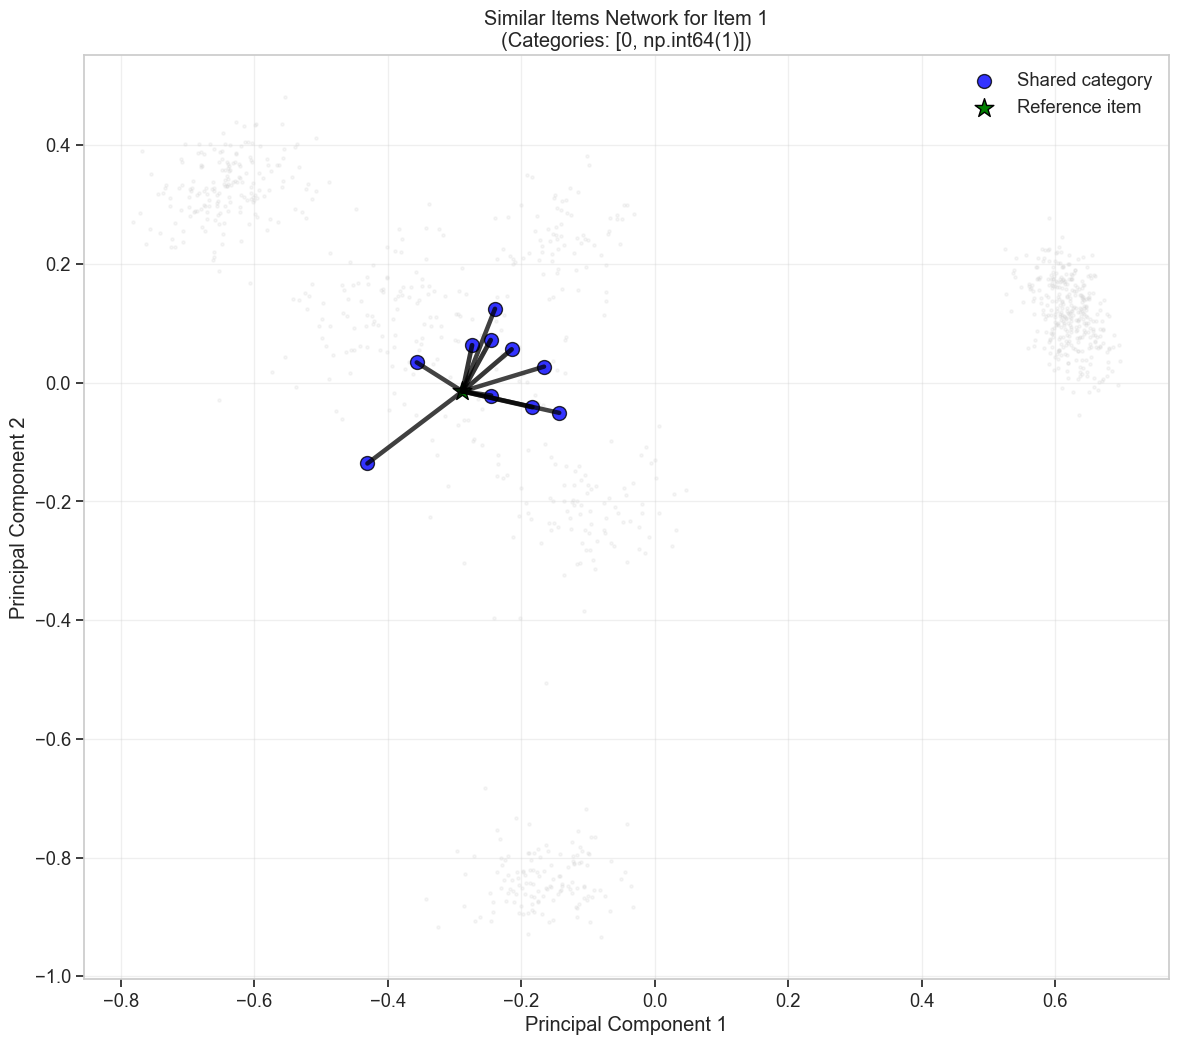

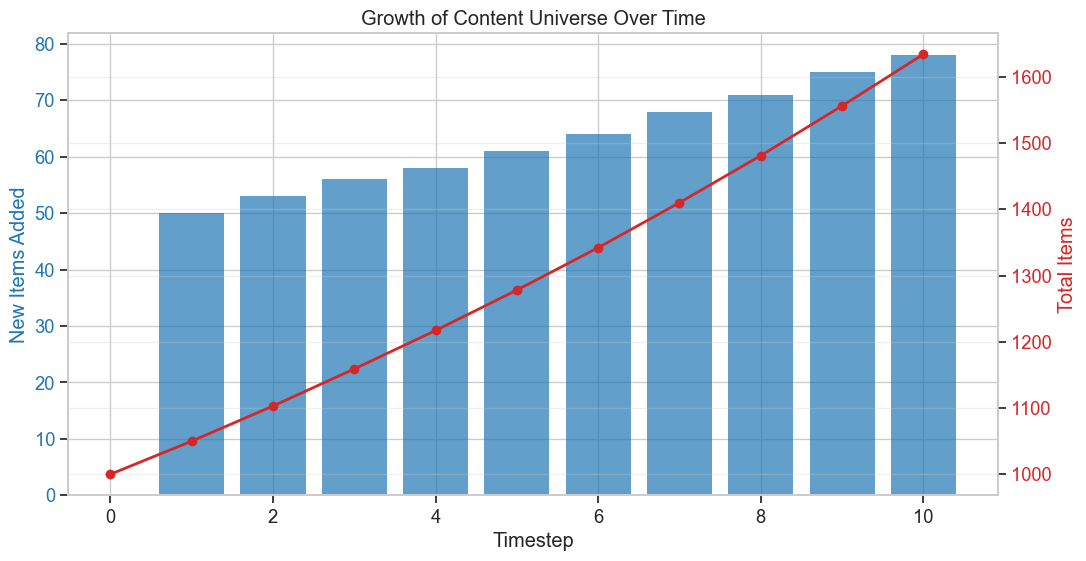

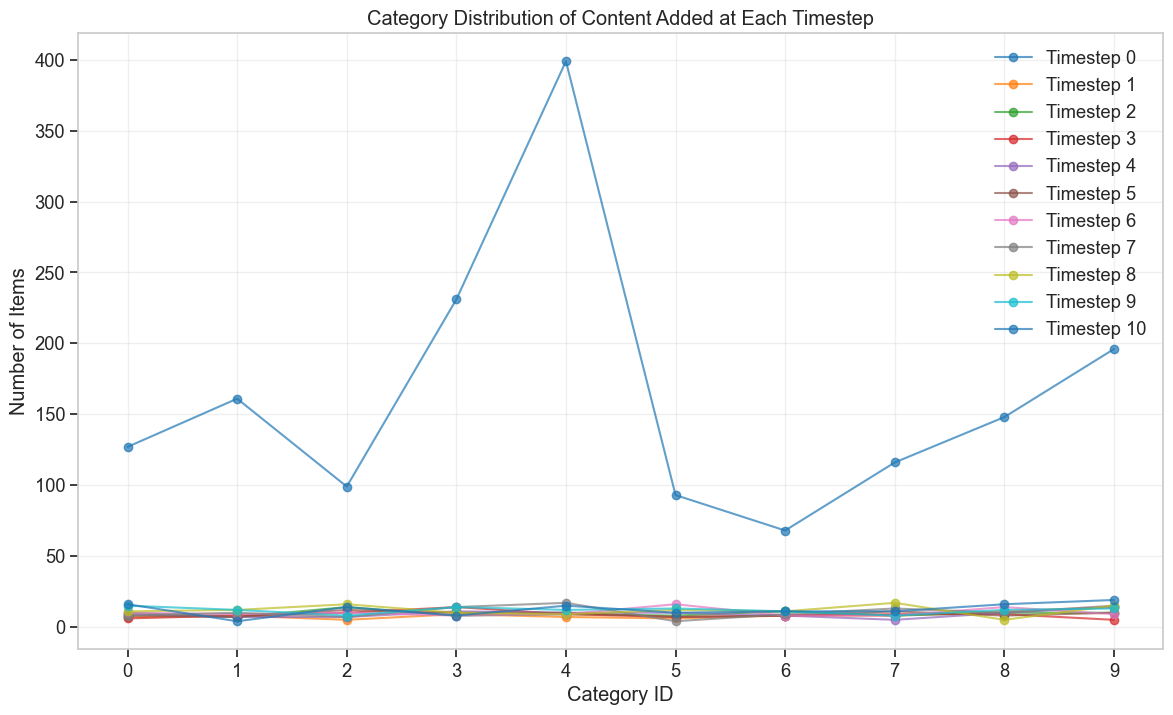

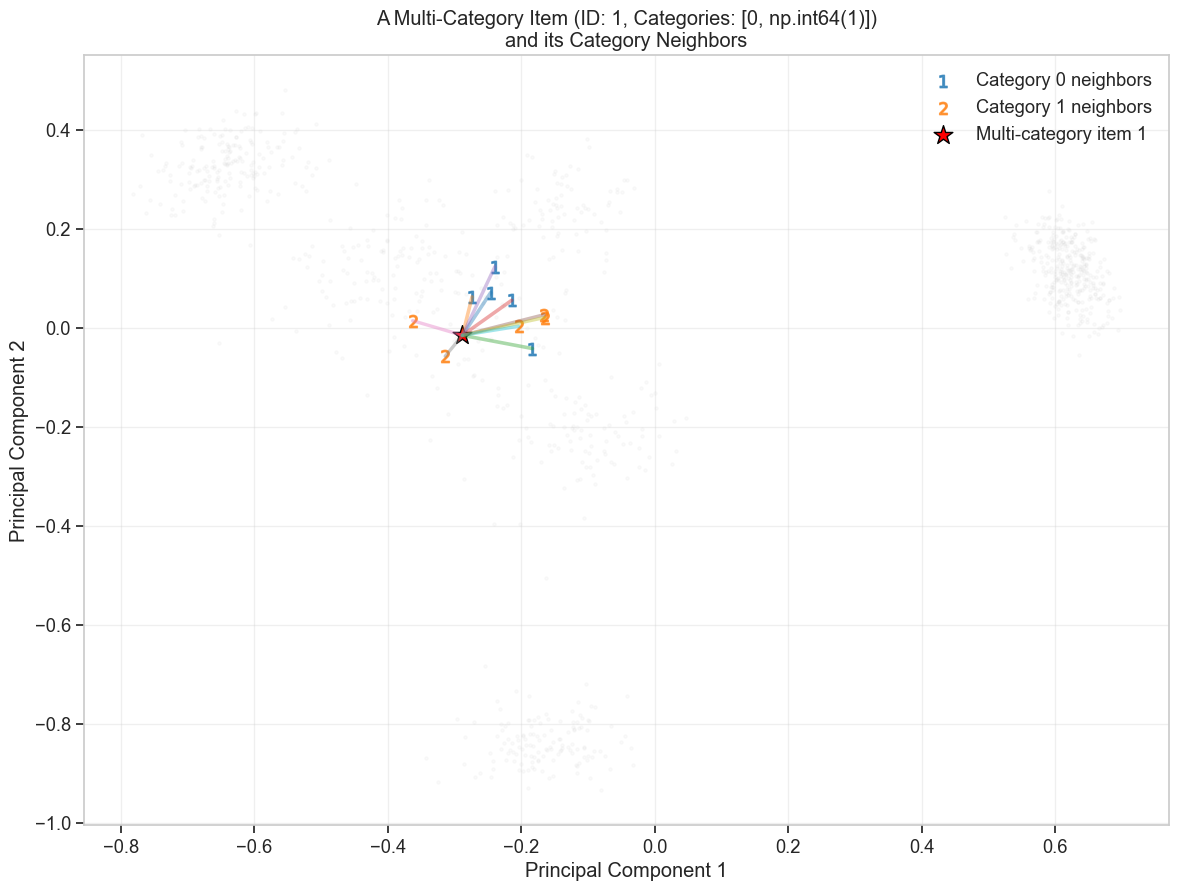

Visualization complete!


In [1]:
# Content Universe Visualization with Multi-Category Support

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from collections import Counter
from bubble_simulation.content import ContentUniverse, Item

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create a content universe with moderate size for visualization
universe = ContentUniverse(
    num_items=1000,
    num_categories=10,
    num_features=50,
    popularity_power_law=1.5,
    dynamic_content=True,
    content_growth_rate=0.05,
    seed=42
)

# Generate initial content
universe.generate_content()

# Convert to DataFrame for easier analysis
df = universe.to_dataframe()

# 1. Visualizing the popularity distribution
plt.figure(figsize=(10, 6))
plt.hist(df['popularity_score'], bins=50, alpha=0.7)
plt.yscale('log')  # Log scale for better visualization of power law
plt.xlabel('Popularity Score')
plt.ylabel('Number of Items (log scale)')
plt.title('Popularity Distribution of Content Items')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Visualizing category distribution
plt.figure(figsize=(12, 6))
# Count primary categories
primary_category_counts = df['primary_category'].value_counts().sort_index()
plt.bar(primary_category_counts.index, primary_category_counts.values, alpha=0.7, label='Primary category')

# Count all category assignments (will be higher due to multi-category items)
all_categories = [cat for cats in df['categories'] for cat in cats]
all_category_counts = pd.Series(Counter(all_categories)).sort_index()
plt.bar(all_category_counts.index, all_category_counts.values, alpha=0.4, label='All category assignments')

plt.xlabel('Category ID')
plt.ylabel('Number of Items')
plt.title('Item Distribution Across Categories')
plt.xticks(range(universe.num_categories))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Visualizing category overlap with an upset plot or matrix
plt.figure(figsize=(12, 8))
# Create a category membership matrix (1 if item belongs to category, 0 otherwise)
category_matrix = np.zeros((len(universe.items), universe.num_categories))
for i, item in enumerate(universe.items):
    for cat in item.categories:
        category_matrix[i, cat] = 1

# Calculate category co-occurrence
co_occurrence = np.dot(category_matrix.T, category_matrix)
# Normalize by diagonal to get conditional probability
for i in range(universe.num_categories):
    if co_occurrence[i, i] > 0:
        co_occurrence[:, i] = co_occurrence[:, i] / co_occurrence[i, i]

# Plot as heatmap
sns.heatmap(co_occurrence, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Category')
plt.ylabel('Category')
plt.title('Category Co-occurrence Matrix\n(Value shows P(row|column))')
plt.show()

# 4. Distribution of the number of categories per item
plt.figure(figsize=(10, 6))
category_counts = df['num_categories'].value_counts().sort_index()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Number of Categories')
plt.ylabel('Number of Items')
plt.title('Distribution of Categories per Item')
plt.xticks(range(1, category_counts.index.max() + 1))
plt.grid(True, alpha=0.3)
plt.show()

# 5. Visualizing content in 2D using PCA
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
features = np.array([item.features for item in universe.items])
features_2d = pca.fit_transform(features)

plt.figure(figsize=(12, 10))
# Create a scatter plot colored by primary category
scatter = plt.scatter(
    features_2d[:, 0], 
    features_2d[:, 1],
    c=df['primary_category'], 
    cmap='tab10',
    alpha=0.7,
    s=50 * df['popularity_score'] / df['popularity_score'].max()  # Size by popularity
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Content Items (colored by primary category)')
plt.colorbar(scatter, label='Primary Category')
# Add a legend for popularity
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4)
popularity_legend = plt.legend(
    handles, 
    ['Low Popularity', '', '', 'High Popularity'],
    loc="upper right",
    title="Popularity"
)
plt.gca().add_artist(popularity_legend)
plt.grid(True, alpha=0.3)
plt.show()

# 6. Visualizing content in 2D with multiple category markers
plt.figure(figsize=(14, 10))
# Plot all items as small gray dots first
plt.scatter(features_2d[:, 0], features_2d[:, 1], color='lightgray', s=10, alpha=0.5)

# For visualization simplicity, only show a few categories with distinct markers
for cat_id in range(min(5, universe.num_categories)):
    # Get items where this is the primary category
    primary_mask = df['primary_category'] == cat_id
    # Get items where this is a secondary category (but not primary)
    secondary_mask = df['categories'].apply(lambda x: cat_id in x and x[0] != cat_id)
    
    # Plot primary category items
    plt.scatter(
        features_2d[primary_mask, 0], 
        features_2d[primary_mask, 1],
        label=f'Category {cat_id} (primary)',
        alpha=0.7,
        s=60
    )
    
    # Plot secondary category items
    plt.scatter(
        features_2d[secondary_mask, 0], 
        features_2d[secondary_mask, 1],
        label=f'Category {cat_id} (secondary)',
        alpha=0.4,
        marker='s',  # Square marker for secondary
        s=30
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization Showing Primary vs. Secondary Categories')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Visualizing item similarity
# Pick a random item with multiple categories
multi_cat_items = [item for item in universe.items if len(item.categories) > 1]
item = multi_cat_items[0] if multi_cat_items else universe.items[0]

# Get similar items
similar_items = universe.get_similar_items(item, n=10)

# Calculate similarities for all items to the selected item
all_similarities = [item.similarity(other_item) for other_item in universe.items]

plt.figure(figsize=(10, 6))
plt.hist(all_similarities, bins=50, alpha=0.7)
# Add vertical lines for the similar items
for similar_item in similar_items:
    similarity = item.similarity(similar_item)
    plt.axvline(x=similarity, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=1.0, color='green', linestyle='-', label='Self-similarity')
plt.xlabel('Similarity to Selected Item')
plt.ylabel('Number of Items')
plt.title(f'Distribution of Item Similarities to Item {item.item_id}\n(Categories: {item.categories})')
plt.legend(['Self-similarity', 'Top 10 similar items', 'All items'])
plt.grid(True, alpha=0.3)
plt.show()

# 8. Similarity network for multi-category item
plt.figure(figsize=(14, 12))
# Plot all items as background
plt.scatter(features_2d[:, 0], features_2d[:, 1], color='lightgray', s=5, alpha=0.2)

# Highlight our selected item and similar items
item_idx = universe.items.index(item)
item_2d = features_2d[item_idx]

# Find indices of similar items
similar_indices = [universe.items.index(i) for i in similar_items]
similar_2d = features_2d[similar_indices]

# Draw lines from item to similar items
for i, similar_index in enumerate(similar_indices):
    similarity = item.similarity(universe.items[similar_index])
    # Adjust alpha based on similarity
    alpha = max(0.2, similarity)
    plt.plot(
        [item_2d[0], features_2d[similar_index, 0]],
        [item_2d[1], features_2d[similar_index, 1]],
        'k-', alpha=alpha, linewidth=1 + 3 * similarity
    )

# Plot similar items with colors based on categories
for i, similar_item in enumerate(similar_items):
    shared_categories = set(item.categories) & set(similar_item.categories)
    if shared_categories:  # If they share categories
        marker = 'o'
        color = 'blue'
        label = 'Shared category' if i == 0 else None
    else:  # If they don't share categories
        marker = 's'
        color = 'red'
        label = 'Different category' if i == 0 else None
        
    plt.scatter(
        similar_2d[i, 0], similar_2d[i, 1],
        s=100, marker=marker, color=color,
        edgecolors='black', alpha=0.8, label=label
    )

# Plot the reference item
plt.scatter(
    item_2d[0], item_2d[1],
    s=200, marker='*', color='green',
    edgecolors='black', alpha=1.0, label='Reference item'
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Similar Items Network for Item {item.item_id}\n(Categories: {item.categories})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 9. Visualizing the effect of dynamic content with categories
# Add new content over several timesteps
new_items_counts = []
total_items_counts = [len(universe.items)]
timesteps = list(range(1, 11))  # 10 timesteps

for t in timesteps:
    new_items = universe.add_new_content(timestep=t)
    new_items_counts.append(len(new_items))
    total_items_counts.append(len(universe.items))

# Plot the growth of content over time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Timestep')
ax1.set_ylabel('New Items Added', color=color)
ax1.bar(timesteps, new_items_counts, alpha=0.7, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Items', color=color)
ax2.plot(range(11), total_items_counts, 'o-', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Growth of Content Universe Over Time')
plt.grid(True, alpha=0.3)
plt.show()

# 10. Category distribution of new content over time
# Create a DataFrame for all items
all_items_df = universe.to_dataframe()

# Create category time evolution plot
plt.figure(figsize=(14, 8))
for t in range(11):  # 0 for initial, 1-10 for new content
    items_at_time = all_items_df[all_items_df['creation_time'] == t]
    if len(items_at_time) == 0:
        continue
        
    # Count categories including multi-category assignments
    all_categories = [cat for cats in items_at_time['categories'] for cat in cats]
    category_counts = pd.Series(Counter(all_categories)).sort_index()
    
    # Fill missing categories with zeros
    all_indices = set(range(universe.num_categories))
    missing_indices = all_indices - set(category_counts.index)
    for idx in missing_indices:
        category_counts[idx] = 0
    category_counts = category_counts.sort_index()
    
    # Plot as a line for this timestep
    plt.plot(
        category_counts.index, 
        category_counts.values, 
        'o-', 
        label=f'Timestep {t}', 
        alpha=0.7
    )

plt.xlabel('Category ID')
plt.ylabel('Number of Items')
plt.title('Category Distribution of Content Added at Each Timestep')
plt.xticks(range(universe.num_categories))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 11. Visualizing an item's multiple categories and their neighbors
# Choose a random item with multiple categories
multi_cat_items = [item for item in universe.items if len(item.categories) > 1]
if multi_cat_items:
    item = multi_cat_items[0]
    item_idx = universe.items.index(item)
    
    # Get similar items for each of its categories
    plt.figure(figsize=(14, 10))
    
    # Plot all items as background
    plt.scatter(features_2d[:, 0], features_2d[:, 1], color='lightgray', s=5, alpha=0.1)
    
    # For each category, get and plot similar items from that category
    for i, category in enumerate(item.categories):
        # Get items from this category (excluding the item itself)
        category_items = [
            i for i in universe.get_items_by_category(category)
            if i.item_id != item.item_id
        ]
        
        # Calculate similarities
        category_similarities = [(i, item.similarity(i)) for i in category_items]
        category_similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Take top 5 from each category
        top_items = [i for i, _ in category_similarities[:5]]
        
        # Get their positions
        top_indices = [universe.items.index(i) for i in top_items]
        cat_items_2d = features_2d[top_indices]
        
        # Plot them with a different color for each category
        plt.scatter(
            cat_items_2d[:, 0],
            cat_items_2d[:, 1],
            label=f'Category {category} neighbors',
            alpha=0.7,
            s=80,
            marker=f'${i+1}$'  # Use numbers as markers
        )
        
        # Draw lines to the item
        for idx in top_indices:
            similarity = item.similarity(universe.items[idx])
            plt.plot(
                [features_2d[item_idx, 0], features_2d[idx, 0]],
                [features_2d[item_idx, 1], features_2d[idx, 1]],
                alpha=0.4, linewidth=1 + 2 * similarity
            )
    
    # Plot the reference multi-category item
    plt.scatter(
        features_2d[item_idx, 0],
        features_2d[item_idx, 1],
        s=200, marker='*', color='red',
        edgecolors='black', alpha=1.0,
        label=f'Multi-category item {item.item_id}'
    )
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'A Multi-Category Item (ID: {item.item_id}, Categories: {item.categories})\nand its Category Neighbors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("Visualization complete!")


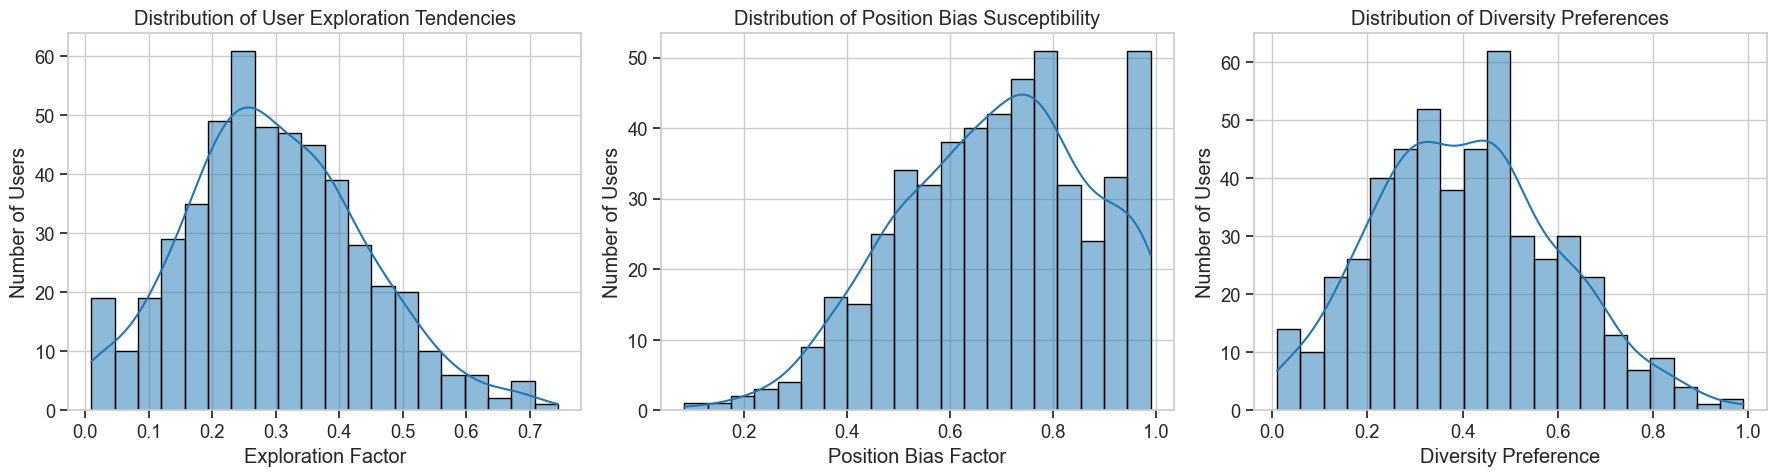

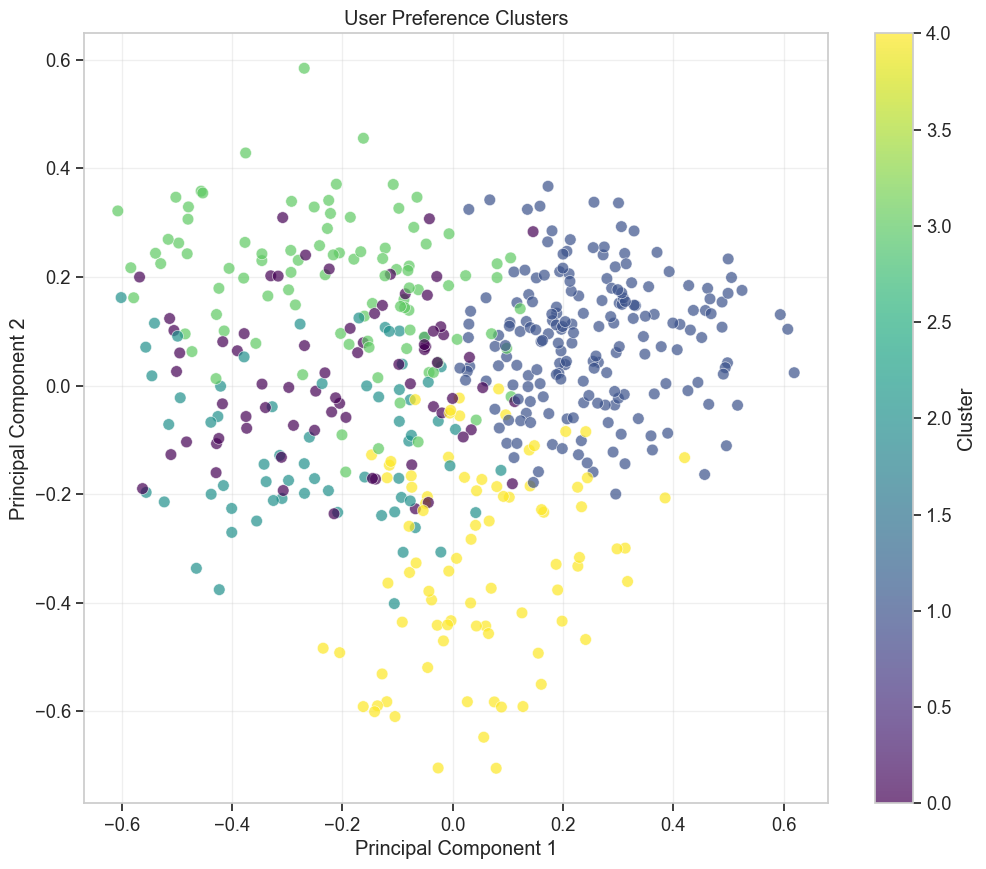

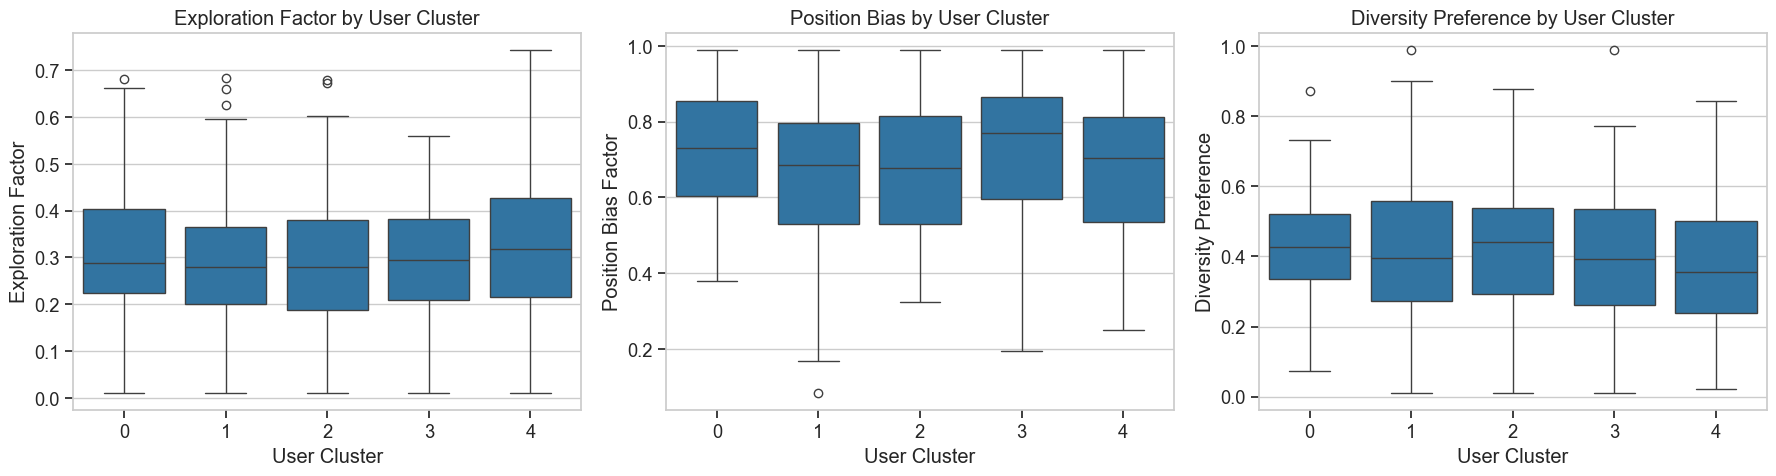

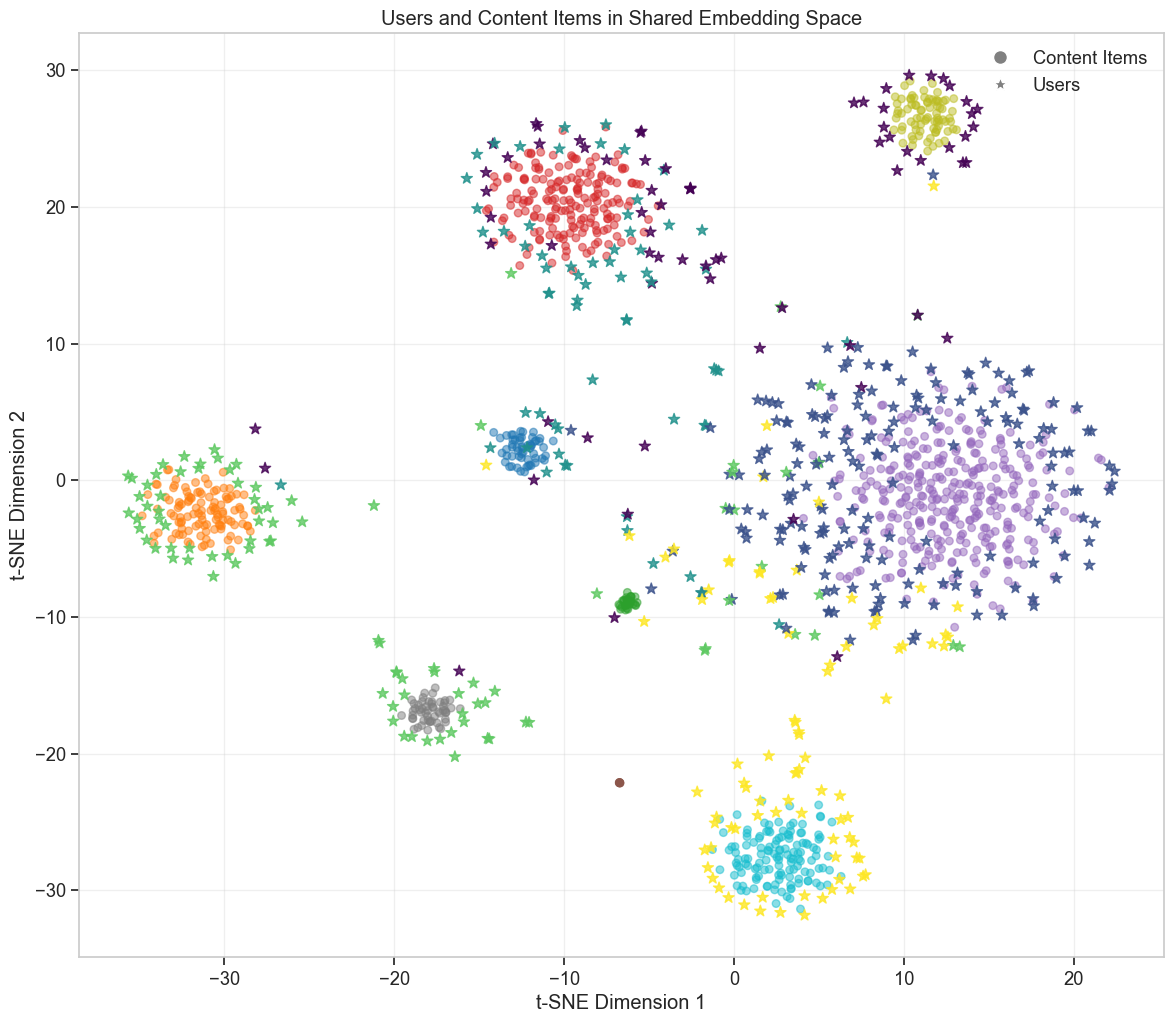

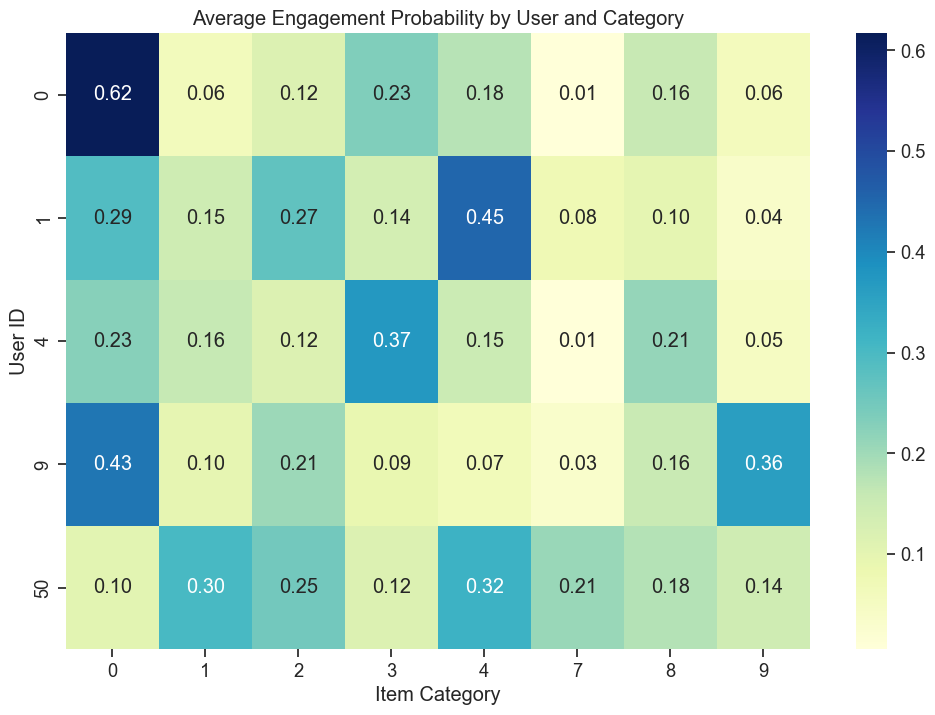

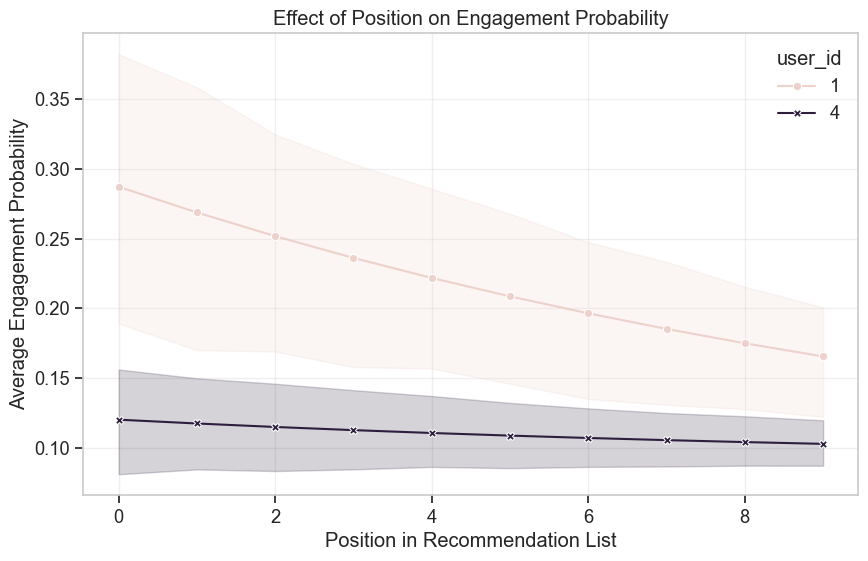

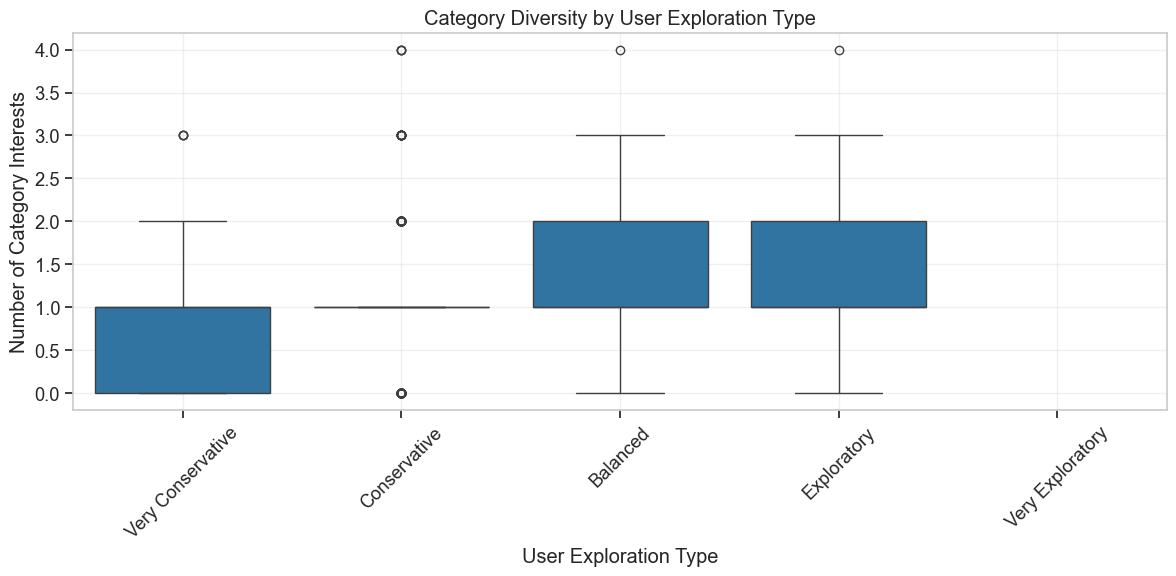

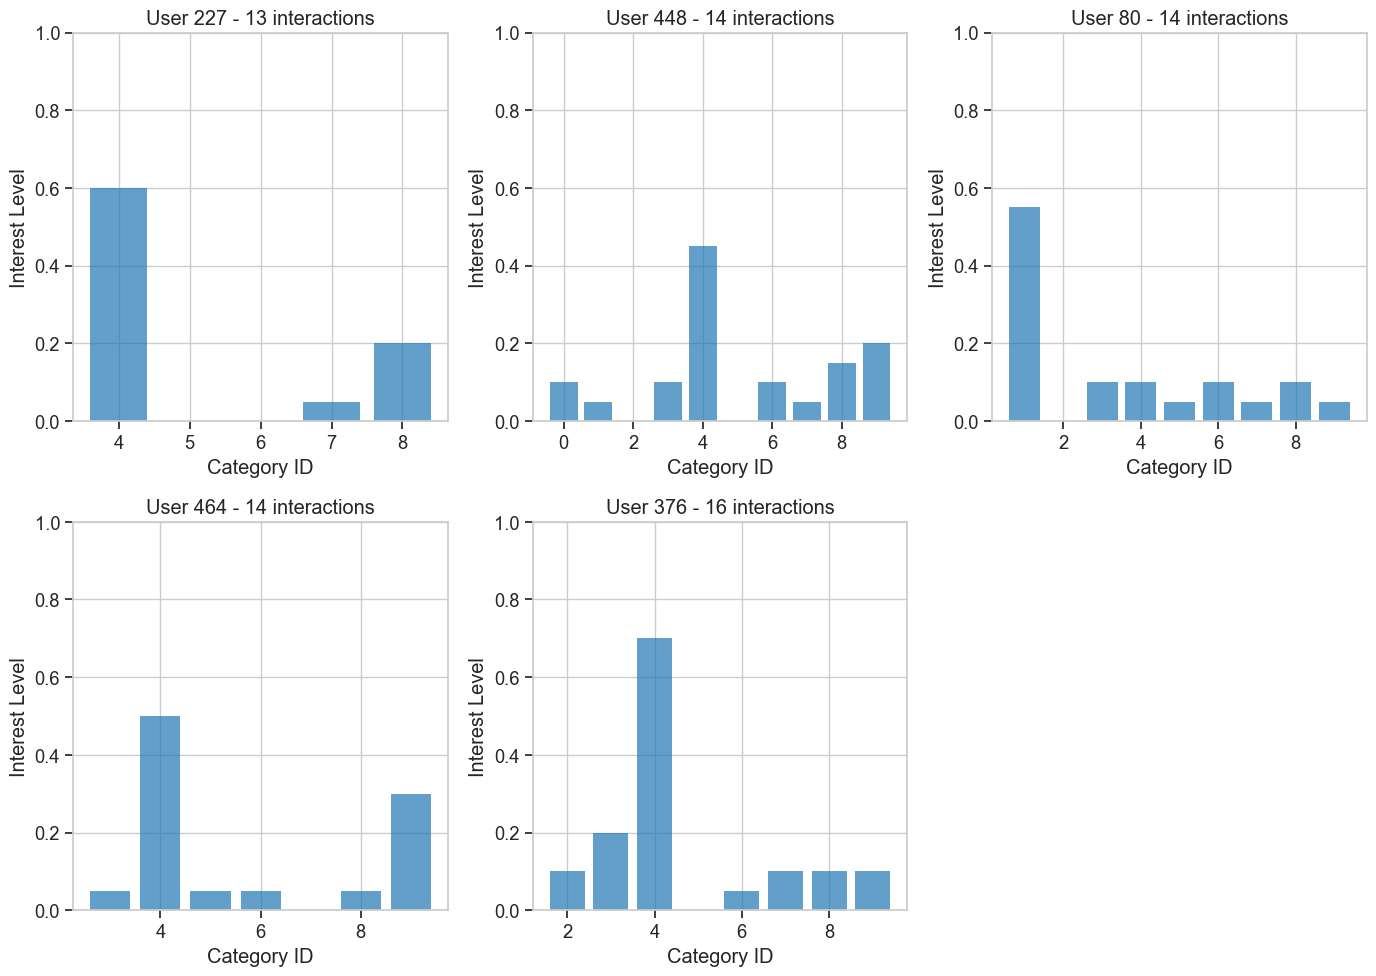

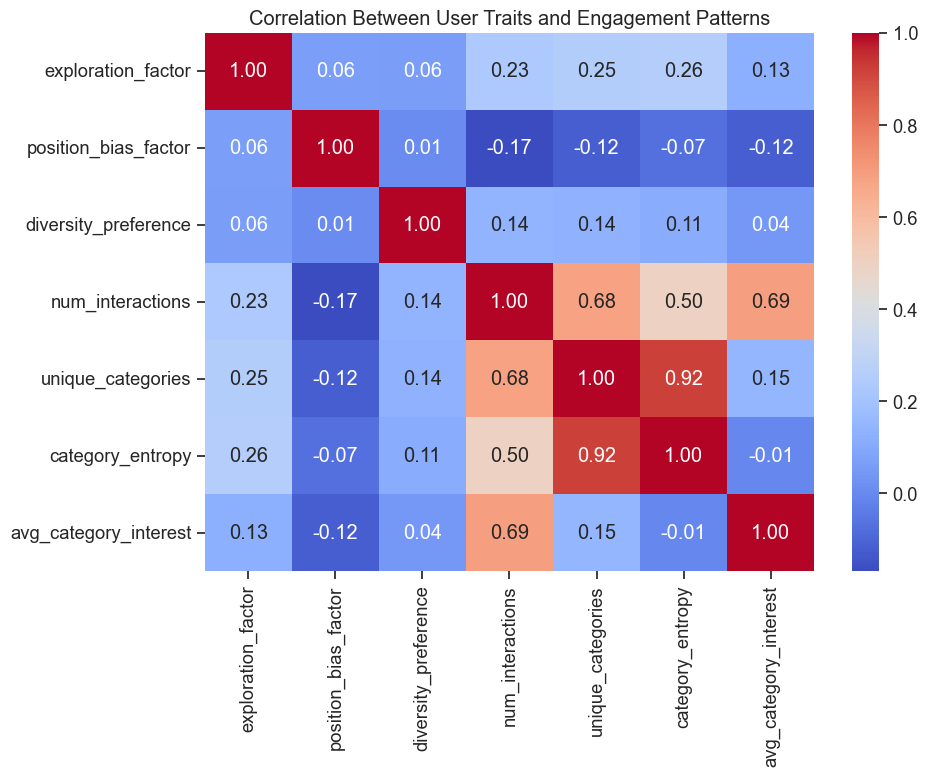

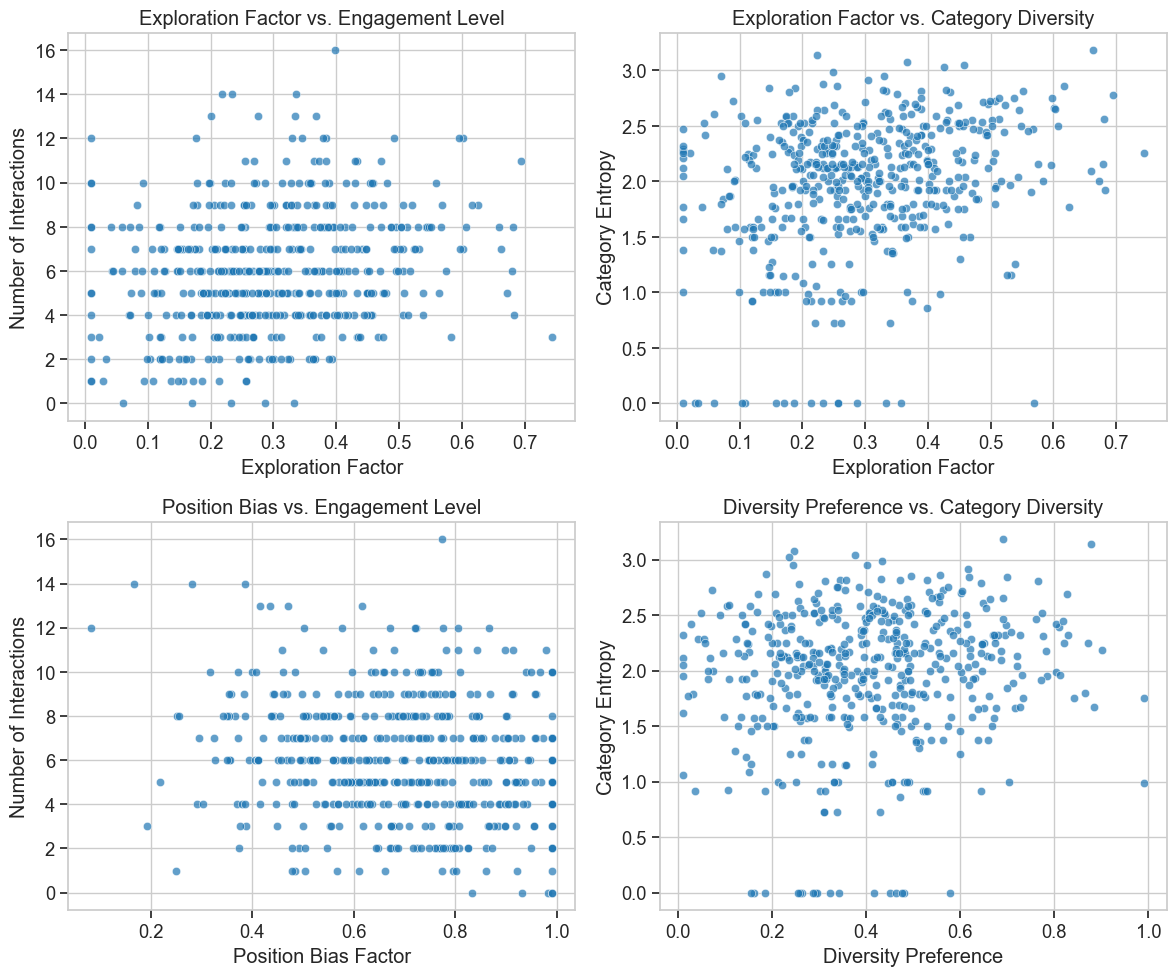

Visualization complete!


In [2]:
# User Preferences and Engagement Visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from bubble_simulation.content import ContentUniverse, Item
from bubble_simulation.users import UserUniverse, User, EngagementModel

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create a content universe
content_universe = ContentUniverse(
    num_items=1000,
    num_categories=10,
    num_features=50,
    popularity_power_law=1.5,
    seed=42
)

# Generate content
content_universe.generate_content()

# Create user universe
user_universe = UserUniverse(
    num_users=500,
    num_user_features=50,  # Match content feature dimension
    exploration_factor_mean=0.3,
    exploration_factor_std=0.15,
    position_bias_factor_mean=0.7,
    position_bias_factor_std=0.2,
    diversity_preference_mean=0.4,
    diversity_preference_std=0.2,
    seed=42
)

# Generate users
user_universe.generate_users(content_universe)

# Generate initial interactions
interactions = user_universe.generate_initial_interactions(
    content_universe, 
    interactions_per_user=30
)

# Convert users to DataFrame for visualization
user_df = user_universe.to_dataframe()

# 1. Visualizing User Trait Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Exploration factor distribution
sns.histplot(user_df['exploration_factor'], bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel('Exploration Factor')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of User Exploration Tendencies')

# Position bias distribution
sns.histplot(user_df['position_bias_factor'], bins=20, kde=True, ax=axes[1])
axes[1].set_xlabel('Position Bias Factor')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Position Bias Susceptibility')

# Diversity preference distribution
sns.histplot(user_df['diversity_preference'], bins=20, kde=True, ax=axes[2])
axes[2].set_xlabel('Diversity Preference')
axes[2].set_ylabel('Number of Users')
axes[2].set_title('Distribution of Diversity Preferences')

plt.tight_layout()
plt.show()

# 2. Visualizing User Preference Clusters in 2D
# Extract preference vectors
preference_columns = [col for col in user_df.columns if col.startswith('preference_')]
preference_matrix = user_df[preference_columns].values

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
user_preferences_2d = pca.fit_transform(preference_matrix)

# Perform clustering to identify user groups
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(preference_matrix)

# Create a scatter plot colored by cluster
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    user_preferences_2d[:, 0], 
    user_preferences_2d[:, 1],
    c=clusters, 
    cmap='viridis',
    alpha=0.7,
    s=70,
    edgecolors='w',
    linewidths=0.5
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('User Preference Clusters')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Exploring the relationship between traits and preferences
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Exploration factor vs. cluster
boxplot1 = sns.boxplot(x=clusters, y=user_df['exploration_factor'], ax=axes[0])
axes[0].set_xlabel('User Cluster')
axes[0].set_ylabel('Exploration Factor')
axes[0].set_title('Exploration Factor by User Cluster')

# Position bias vs. cluster
boxplot2 = sns.boxplot(x=clusters, y=user_df['position_bias_factor'], ax=axes[1])
axes[1].set_xlabel('User Cluster')
axes[1].set_ylabel('Position Bias Factor')
axes[1].set_title('Position Bias by User Cluster')

# Diversity preference vs. cluster
boxplot3 = sns.boxplot(x=clusters, y=user_df['diversity_preference'], ax=axes[2])
axes[2].set_xlabel('User Cluster')
axes[2].set_ylabel('Diversity Preference')
axes[2].set_title('Diversity Preference by User Cluster')

plt.tight_layout()
plt.show()

# 4. Visualizing User-Content Interaction Space
# Use t-SNE to visualize users and content in the same space
# Combine user preferences and content features
user_preferences = np.array([user.preference_vector for user in user_universe.users])
content_features = np.array([item.features for item in content_universe.items])

# Take a sample for clearer visualization
max_points = 1000
if len(content_features) > max_points:
    # Sample content items
    content_indices = np.random.choice(len(content_features), max_points, replace=False)
    content_sample = content_features[content_indices]
    # Get categories for coloring
    content_categories = [content_universe.items[i].categories[0] for i in content_indices]
else:
    content_sample = content_features
    content_categories = [item.categories[0] for item in content_universe.items]

# Sample users too if needed
if len(user_preferences) > max_points:
    user_indices = np.random.choice(len(user_preferences), max_points, replace=False)
    user_sample = user_preferences[user_indices]
    user_clusters = clusters[user_indices]
else:
    user_sample = user_preferences
    user_clusters = clusters

# Combine samples
combined_features = np.vstack([user_sample, content_sample])

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_2d = tsne.fit_transform(combined_features)

# Split back into user and content parts
user_2d = combined_2d[:len(user_sample)]
content_2d = combined_2d[len(user_sample):]

# Plot users and content in the same space
plt.figure(figsize=(14, 12))

# Plot content items
scatter1 = plt.scatter(
    content_2d[:, 0], 
    content_2d[:, 1],
    c=content_categories,
    cmap='tab10',
    alpha=0.5,
    s=30,
    marker='o',
    label='Content Items'
)

# Plot users
scatter2 = plt.scatter(
    user_2d[:, 0], 
    user_2d[:, 1],
    c=user_clusters,
    cmap='viridis',
    alpha=0.8,
    s=70,
    marker='*',
    label='Users'
)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Users and Content Items in Shared Embedding Space')
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Content Items'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=10, label='Users')
], loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# 5. Visualizing Engagement Probabilities
# Select a few users from different clusters
selected_user_indices = [np.where(clusters == i)[0][0] for i in range(min(5, len(np.unique(clusters))))]
selected_users = [user_universe.users[i] for i in selected_user_indices]

# Select a range of content items
content_sample_indices = np.random.choice(len(content_universe.items), 100, replace=False)
content_sample = [content_universe.items[i] for i in content_sample_indices]

# Create engagement model
engagement_model = EngagementModel()

# Calculate engagement probabilities for each user-item pair
engagement_data = []

for user_idx, user in enumerate(selected_users):
    for item in content_sample:
        # Calculate engagement probability at position 0 (top position)
        engagement_prob = engagement_model.calculate_engagement_probability(
            user, item, 0, user.interaction_history
        )
        
        # Get item's primary category
        primary_category = item.categories[0] if item.categories else -1
        
        # Add to data
        engagement_data.append({
            'user_id': user.user_id,
            'user_cluster': clusters[selected_user_indices[user_idx]],
            'item_id': item.item_id,
            'item_category': primary_category,
            'engagement_probability': engagement_prob,
            'exploration_factor': user.exploration_factor,
            'item_popularity': item.popularity_score
        })

# Convert to DataFrame
engagement_df = pd.DataFrame(engagement_data)

# Create a heatmap of engagement probabilities by user and item category
plt.figure(figsize=(12, 8))
engagement_pivot = engagement_df.pivot_table(
    index='user_id', 
    columns='item_category', 
    values='engagement_probability', 
    aggfunc='mean'
)
sns.heatmap(engagement_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Item Category')
plt.ylabel('User ID')
plt.title('Average Engagement Probability by User and Category')
plt.show()

# 6. Position Bias Effect
# Calculate engagement probability at different positions
position_data = []

for user in selected_users[:2]:  # Just use first two users for clarity
    for item in content_sample[:10]:  # And first 10 items
        for position in range(10):
            # Calculate engagement probability at different positions
            engagement_prob = engagement_model.calculate_engagement_probability(
                user, item, position, user.interaction_history
            )
            
            # Add to data
            position_data.append({
                'user_id': user.user_id,
                'item_id': item.item_id,
                'position': position,
                'engagement_probability': engagement_prob
            })

# Convert to DataFrame
position_df = pd.DataFrame(position_data)

# Plot position decay curves
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=position_df, 
    x='position', 
    y='engagement_probability',
    hue='user_id',
    style='user_id',
    markers=True,
    dashes=False
)
plt.xlabel('Position in Recommendation List')
plt.ylabel('Average Engagement Probability')
plt.title('Effect of Position on Engagement Probability')
plt.grid(True, alpha=0.3)
plt.show()

# 7. Comparing Exploration and Exploitation Users
# Group users by exploration factor
user_df['explorer_type'] = pd.cut(
    user_df['exploration_factor'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Conservative', 'Conservative', 'Balanced', 'Exploratory', 'Very Exploratory']
)

# Plot engagement rates by explorer type
category_interests = [col for col in user_df.columns if col.startswith('category_interest_')]
if category_interests:
    # Calculate average number of category interests per user type
    user_df['num_category_interests'] = user_df[category_interests].gt(0.1).sum(axis=1)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=user_df, 
        x='explorer_type', 
        y='num_category_interests'
    )
    plt.xlabel('User Exploration Type')
    plt.ylabel('Number of Category Interests')
    plt.title('Category Diversity by User Exploration Type')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 8. Visualizing Category Interest Development
# Find users with most interactions
interaction_counts = [len(user.interaction_history) for user in user_universe.users]
active_user_indices = np.argsort(interaction_counts)[-5:]  # Top 5 most active
active_users = [user_universe.users[i] for i in active_user_indices]

# Plot category interests for these users
plt.figure(figsize=(14, 10))

for i, user in enumerate(active_users):
    # Get category interests
    categories = sorted(user.category_interests.keys())
    interests = [user.category_interests[cat] for cat in categories]
    
    # Create subplot
    plt.subplot(2, 3, i+1)
    plt.bar(categories, interests, alpha=0.7)
    plt.xlabel('Category ID')
    plt.ylabel('Interest Level')
    plt.title(f'User {user.user_id} - {len(user.interaction_history)} interactions')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# 9. Visualizing Engagement Patterns
# Calculate engagement metrics for all users
engagement_metrics = []

for user in user_universe.users:
    metrics = {
        'user_id': user.user_id,
        'exploration_factor': user.exploration_factor,
        'position_bias_factor': user.position_bias_factor,
        'diversity_preference': user.diversity_preference,
        'num_interactions': len(user.interaction_history),
        'unique_categories': len(user.category_interests),
        'avg_category_interest': np.mean(list(user.category_interests.values())) if user.category_interests else 0
    }
    
    # Count category interactions
    category_counts = {}
    for item in user.interaction_history:
        for category in item.categories:
            if category not in category_counts:
                category_counts[category] = 0
            category_counts[category] += 1
    
    # Calculate category entropy (diversity measure)
    if category_counts:
        total = sum(category_counts.values())
        proportions = [count / total for count in category_counts.values()]
        entropy = -sum(p * np.log2(p) for p in proportions)
        metrics['category_entropy'] = entropy
    else:
        metrics['category_entropy'] = 0
        
    engagement_metrics.append(metrics)

# Convert to DataFrame
engagement_metrics_df = pd.DataFrame(engagement_metrics)

# Create a correlation matrix
plt.figure(figsize=(10, 8))
correlation_cols = ['exploration_factor', 'position_bias_factor', 'diversity_preference',
                    'num_interactions', 'unique_categories', 'category_entropy', 'avg_category_interest']
corr_matrix = engagement_metrics_df[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Between User Traits and Engagement Patterns')
plt.tight_layout()
plt.show()

# 10. Exploration vs. Engagement Relationship
plt.figure(figsize=(12, 10))

# Plot exploration vs. number of interactions
plt.subplot(2, 2, 1)
sns.scatterplot(
    data=engagement_metrics_df, 
    x='exploration_factor', 
    y='num_interactions',
    alpha=0.7
)
plt.xlabel('Exploration Factor')
plt.ylabel('Number of Interactions')
plt.title('Exploration Factor vs. Engagement Level')

# Plot exploration vs. category diversity
plt.subplot(2, 2, 2)
sns.scatterplot(
    data=engagement_metrics_df, 
    x='exploration_factor', 
    y='category_entropy',
    alpha=0.7
)
plt.xlabel('Exploration Factor')
plt.ylabel('Category Entropy')
plt.title('Exploration Factor vs. Category Diversity')

# Plot position bias vs. number of interactions
plt.subplot(2, 2, 3)
sns.scatterplot(
    data=engagement_metrics_df, 
    x='position_bias_factor', 
    y='num_interactions',
    alpha=0.7
)
plt.xlabel('Position Bias Factor')
plt.ylabel('Number of Interactions')
plt.title('Position Bias vs. Engagement Level')

# Plot diversity preference vs. category entropy
plt.subplot(2, 2, 4)
sns.scatterplot(
    data=engagement_metrics_df, 
    x='diversity_preference', 
    y='category_entropy',
    alpha=0.7
)
plt.xlabel('Diversity Preference')
plt.ylabel('Category Entropy')
plt.title('Diversity Preference vs. Category Diversity')

plt.tight_layout()
plt.show()

print("Visualization complete!")